In [211]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/TrueCue/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TrueCue


# Cluster countries by 14-day new case notification rate over time

In [212]:
# clustering algorithm https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
!pip install hdbscan

In [213]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan

In [214]:
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df_pvt=df.pivot(index='date', columns='iso_code', values='new_cases').fillna(0.)

#sorted list of countries with a population over 5M
ctries=df[df.date=='2020-10-16'][df.population>=5000000][['iso_code', 'population']].sort_values('population', ascending=False).iso_code.to_list()[1:]

df_14_day=pd.DataFrame()
for col in df_pvt[ctries].columns:
  df_14_day[col]=df_pvt[col].rolling(window=14).sum()

df_14_day.fillna(0., inplace=True)

for col in df_14_day.columns:
  popn=(df.loc[(df.date=='2020-10-01') & (df.iso_code==col), 'population']/100000).values
  if len(popn) > 0:
    df_14_day[col]=df_14_day[col]/popn
  else:
    print (col)

df_14_day = df_14_day.T.reset_index().rename(columns={'index':'iso_code'})
df_14_day=df_14_day.merge(df[['iso_code','continent','location']], how='left').drop_duplicates().set_index('iso_code')

color_dict={'Asia':1, 'North America':2, 'South America':3, 'Africa':4, 'Europe':5, 'Oceania':6}
df_14_day['color']=df_14_day.continent.apply(lambda x: color_dict[x])
df_14_day['labels']=0

df_14_day.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,...,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,continent,location,color,labels
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004099,0.002223,0.002223,0.002223,0.00132,0.002501,0.010908,0.012228,0.022719,0.032446,0.039185,0.057180,0.087819,0.134021,0.188700,0.310493,0.412346,0.533237,0.670523,0.814897,0.985393,1.179443,1.393849,1.653137,1.905339,2.106892,2.313725,...,0.021399,0.020843,0.021399,0.021607,0.020982,0.021677,0.021468,0.020635,0.020565,0.020009,0.019870,0.019870,0.019801,0.019315,0.018967,0.019176,0.018828,0.018064,0.018828,0.018620,0.019454,0.021121,0.021955,0.022372,0.022858,0.022580,0.022927,0.023692,0.023483,0.023692,0.024386,0.023831,0.024595,0.024664,0.024664,0.023970,Asia,China,1,0
IND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000072,0.000072,0.000072,0.000145,0.000145,0.000217,0.000217,0.000217,0.000217,0.000217,...,92.603329,93.103690,93.246660,92.968328,92.915719,92.454924,91.786303,91.025508,90.140873,89.722613,89.005152,88.047184,87.347838,86.545450,85.462844,84.458427,83.242779,82.335608,81.334452,80.515759,79.937210,78.809967,77.933883,76.903669,75.784977,74.680125,73.450926,72.065930,70.753398,69.502388,68.490942,67.134424,66.085370,64.780664,63.136828,61.967992,Asia,India,1,0
USA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000302,0.000302,0.000302,0.000302,0.000604,0.000604,0.001511,0.001511,0.001511,0.001511,0.001813,0.002115,0.002417,0.003323,0.003021,0.003021,0.003323,0.003323,0.003021,...,158.247375,157.986954,156.825332,159.634071,168.366025,171.745152,173.558733,175.584699,177.684984,179.058991,179.777112,179.220319,176.665657,181.917578,182.281322,183.568925,186.700018,185.204259,181.443564,182.880109,185.977365,189.780053,190.707236,193.396943,195.617167,198.231949,201.102017,206.359981,212.104346,216.873190,218.671363,222.581302,228.458898,233.137713,237.607768,242.217398,North America,United States,2,0
IDN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,17.680374,17.907777,18.288000,18.487252,18.961068,19.335807,19.759171,20.041779,20.438820,20.686330,20.777365,20.911905,21.092877,21.210234,21.407292,21.563037,21.504176,21.505272,21.302731,21.297247,21.323935,21.402905,21.136383,21.063263,21.291031,21.202556,21.167459,21.110060,21.196707,21.190857,21.298343,21.339656,21.248622,21.082640,20.983563,20.830742,Asia,Indonesia,1,0
PAK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.1119

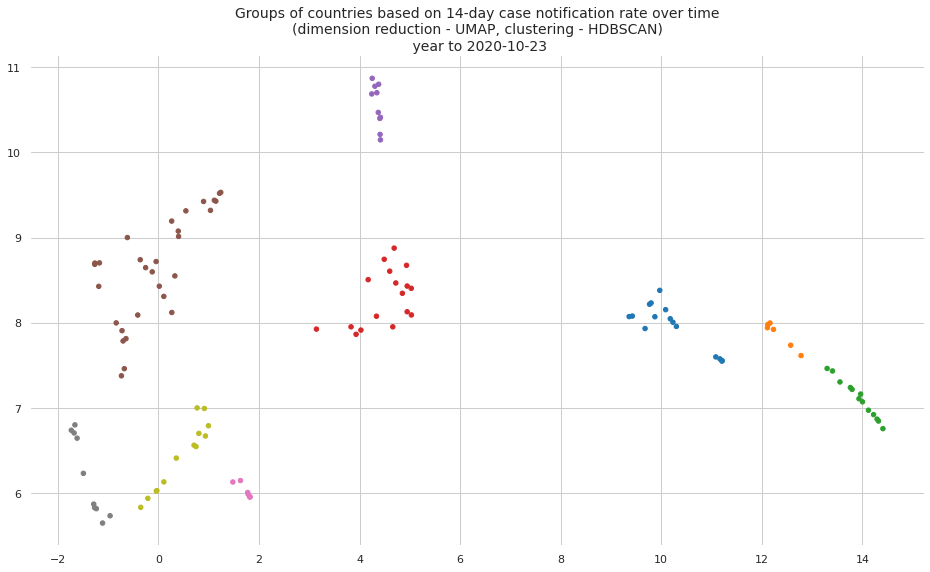

In [215]:
sns.set(style='whitegrid', rc={'figure.figsize':(16,9)})

clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0,
    n_components=2,
    random_state=101,
).fit_transform(df_14_day.iloc[:,:-4])

labels = hdbscan.HDBSCAN(
    min_samples=3,
    min_cluster_size=6,
).fit_predict(clusterable_embedding)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            s=20,
            c=cm.tab10(labels))
plt.title('Groups of countries based on 14-day case notification rate over time\n(dimension reduction - UMAP, clustering - HDBSCAN)\n year to '+df_14_day.columns[-5], fontsize=14)
plt.box(False)
plt.savefig('groups.png', dpi=300);

In [216]:
### WARNING Groups change each time new data is added by Our World in Data
df_14_day['labels']=labels
df_14_day.labels.value_counts().sort_index()
for label in sorted(df_14_day.labels.unique()):
  print ('Group '+str(label),len(df_14_day[df_14_day.labels==label].location.to_list()),df_14_day[df_14_day.labels==label].location.to_list())

Group 0 15 ['Nigeria', 'Myanmar', 'South Korea', 'Uganda', 'Angola', 'Malaysia', 'Mozambique', 'Sri Lanka', 'Malawi', 'Syria', 'Rwanda', 'Benin', 'Cuba', 'Togo', 'Liberia']
Group 1 6 ['Democratic Republic of Congo', 'Sudan', 'Mali', 'Somalia', 'South Sudan', 'Sierra Leone']
Group 2 13 ['China', 'Vietnam', 'Thailand', 'Tanzania', 'Yemen', 'Niger', 'Taiwan', 'Burkina Faso', 'Cambodia', 'Chad', 'Burundi', 'Papua New Guinea', 'Laos']
Group 3 17 ['India', 'Indonesia', 'Bangladesh', 'Japan', 'Ethiopia', 'Philippines', 'Kenya', 'Algeria', 'Uzbekistan', 'Ghana', 'Venezuela', 'Madagascar', 'Australia', 'Zambia', 'Zimbabwe', 'Greece', 'Congo']
Group 4 10 ['Pakistan', 'Egypt', 'Afghanistan', 'Cameroon', "Cote d'Ivoire", 'Senegal', 'Guinea', 'Haiti', 'Tajikistan', 'Nicaragua']
Group 5 30 ['Turkey', 'Germany', 'United Kingdom', 'France', 'Italy', 'Ukraine', 'Iraq', 'Poland', 'Canada', 'Morocco', 'Nepal', 'Romania', 'Netherlands', 'Tunisia', 'Belgium', 'Czech Republic', 'Jordan', 'Portugal', 'Hungar

# Colour by continent - continent not important in forming the clusters

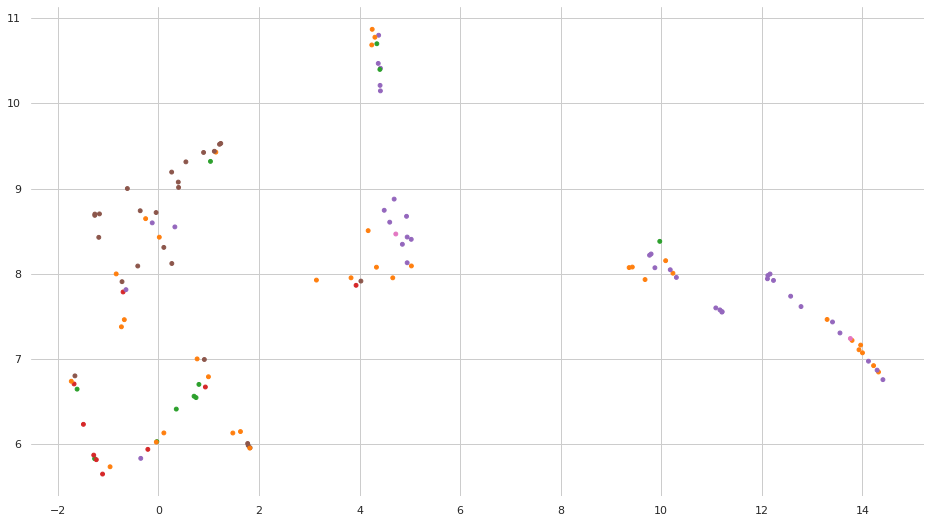

In [217]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            s=15,
            c=cm.tab10(df_14_day.color))
plt.box(False);

# Plot timeline for each cluster. Is there a pattern?

In [218]:
# sort by average rate for each group to plot in order of best to worst
lst=[]
for label in sorted(df_14_day.labels.unique()):
  lst.append((df_14_day[df_14_day.labels==label].iloc[:,:-4].mean().mean(),label))
lst=sorted(lst)

grp_lst=[]
for i,tup in enumerate(lst):
  grp_lst.append(lst[i][1])

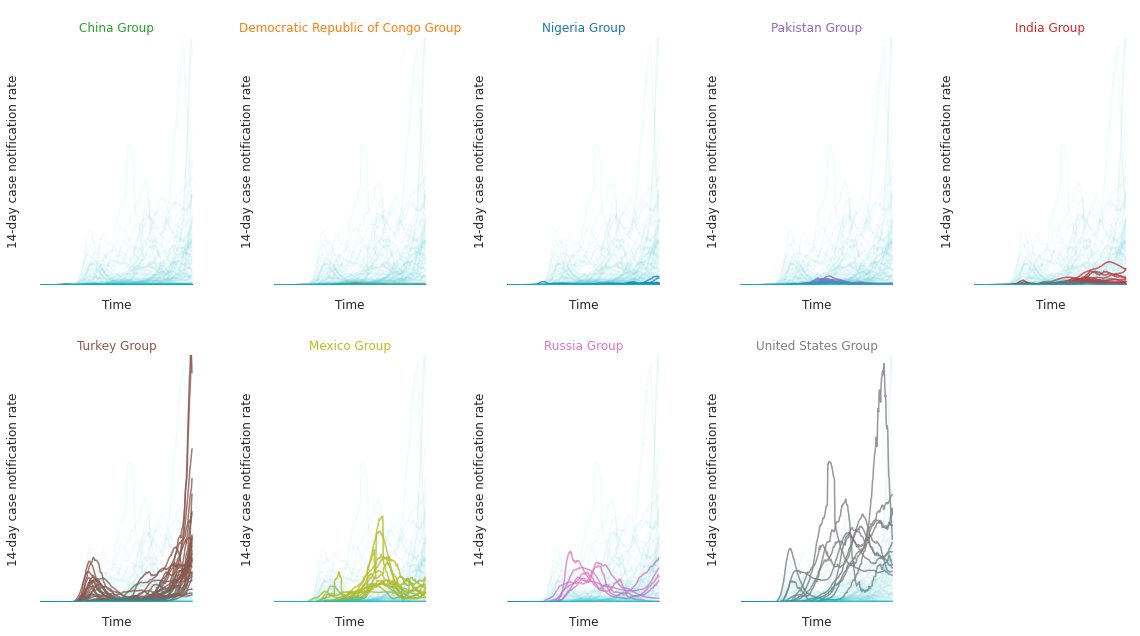

<Figure size 1152x648 with 0 Axes>

In [219]:
sns.set(style='white', rc={'figure.figsize':(16,9)})

axes=[]
fig=plt.figure()

for i,label in enumerate(grp_lst):

  axes.append(fig.add_subplot(2, int(.5+len(grp_lst)/2), i+1))
  subplot_title=('\n'+df_14_day[df_14_day.labels==label].location.to_list()[0]+' Group')
  axes[-1].set_title(subplot_title, color=cm.tab10(label))  

  for ctry in df_14_day[df_14_day.labels==label].index:
    alpha=0.8
    plt.plot(df_14_day.columns[:-4],df_14_day.loc[ctry][:-4], c=cm.tab10(label), alpha=alpha)

  for ctry in df_14_day[df_14_day.labels!=label].index:
    alpha=0.05
    label=10
    plt.plot(df_14_day.columns[:-4],df_14_day.loc[ctry][:-4], c=cm.tab10(label), alpha=alpha)
  
  plt.ylim(0,1000)
  axes[-1].set_frame_on(False)
  axes[-1].set_yticklabels([])
  axes[-1].set_xticklabels([])
  axes[-1].set_xlabel('Time')
  axes[-1].set_ylabel('14-day case notification rate')
  fig.tight_layout()

plt.show()
plt.savefig('time.png', dpi=300);

# World map coloured by groups

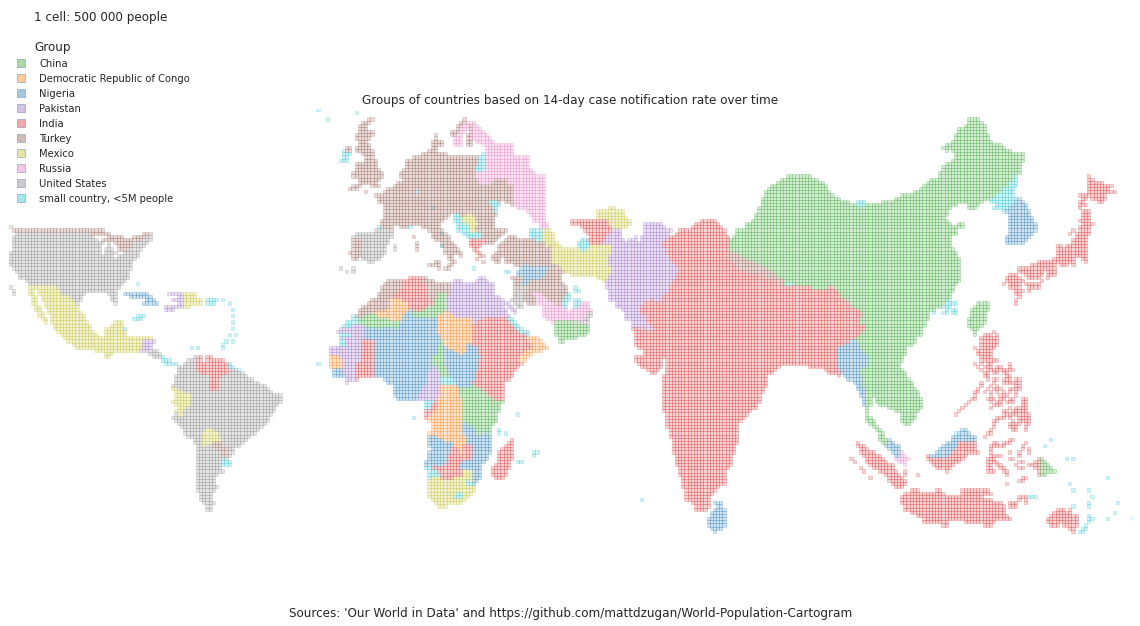

In [220]:
iso_3166=pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/slim-3/slim-3.csv',
                     dtype={'name':'str','alpha-3':'str','country-code':'float64'})
cells = pd.read_csv("https://raw.githubusercontent.com/mattdzugan/World-Population-Cartogram/master/data/year_2018__cell_500k/squares_and_triangles/cells.csv")
images=[]

for date in [df_14_day.columns[-5]]:
  one_day_df = df_14_day[[date,'labels']]
  one_day_df = one_day_df.reset_index()
  one_day_df = one_day_df.merge(iso_3166, left_on='iso_code', right_on='alpha-3', how='left')
  one_day_df['country-code'] = one_day_df['country-code'].fillna(0).astype('int')

  cells_day = cells.merge(one_day_df[['country-code','labels']], left_on='CountryCode', right_on='country-code', how='left')
  cells_day.labels.fillna(10,inplace=True)
  cells_day.labels=cells_day.labels.astype(int)

  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot(111, aspect='equal')
  plt.xlim([0, max(cells_day["X"]+1)])
  plt.ylim([0, max(cells_day["Y"]+1)])
  n=cells_day.shape[0]
  patches = []
  for i in range(0,n):
    patches.append(Rectangle((cells_day.loc[i,"X"]+.5, cells_day.loc[i,"Y"]+.5),1,1))
  ax.add_collection(PatchCollection(patches, color=cm.tab10(cells_day.labels), alpha=0.2))

  sq1  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[0]))
  sq2  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[1]))
  sq3  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[2]))
  sq4  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[3]))
  sq5  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[4]))
  sq6  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[5]))
  sq7  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[6]))
  sq8  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[7]))
  sq9  = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(grp_lst[8]))
  sq10 = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor=cm.tab10(9))

  plt.legend((sq1, sq2, sq3, sq4, sq5, sq6, sq7, sq8, sq9, sq10),
             (df_14_day[df_14_day.labels==grp_lst[0]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[1]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[2]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[3]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[4]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[5]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[6]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[7]].location.to_list()[0],
              df_14_day[df_14_day.labels==grp_lst[8]].location.to_list()[0],
              'small country, <5M people'),
             numpoints=1,
             loc=(.0,.77),
             title='1 cell: 500 000 people\n\nGroup',
             fontsize=10,
             frameon=False)

  plt.title('Groups of countries based on 14-day case notification rate over time')
  plt.axis('off')
  plt.figtext(0.5, 0.01, "Sources: 'Our World in Data' and https://github.com/mattdzugan/World-Population-Cartogram", ha='center')
  plt.tight_layout()
  plt.savefig('world_groups.png', dpi=300)
  plt.show()
  plt.close()

# Relationship between groups and key developmental metrics

In [221]:
df=pd.read_csv('from_TrueCue/COVID19 Hackathon Dataset.csv')
df_rol=df_14_day.merge(df[['Country Code','Rule_of_Law']], left_index=True, right_on='Country Code').drop_duplicates()[['labels','Rule_of_Law']]
df_rol.corr()

,labels,Rule_of_Law
labels,1.000000,0.257699
Rule_of_Law,0.257699,1.000000


In [222]:
df_corr=df_14_day[['labels','2020-10-23']].merge(df[df.columns[9:]], left_index=True, right_on='Country Code').drop(columns=['2020-10-23','RunTot_New_Cases','RunTot_New_Deaths','Year']).drop_duplicates()
pd.DataFrame(df_corr.corr().labels).apply(lambda x: (100*abs(x)+.5).astype(int)).sort_values('labels',ascending=False)

,labels
labels,100
Obesity_Rate,63
Fertility_Rate,52
Government_Healthcare_Spend,41
GDP_PPP,38
Government_Effectiveness,35
Hospital Beds Year,35
Population Aged 65 and above % of Total,31
Urban_Population,30
Corruption,27


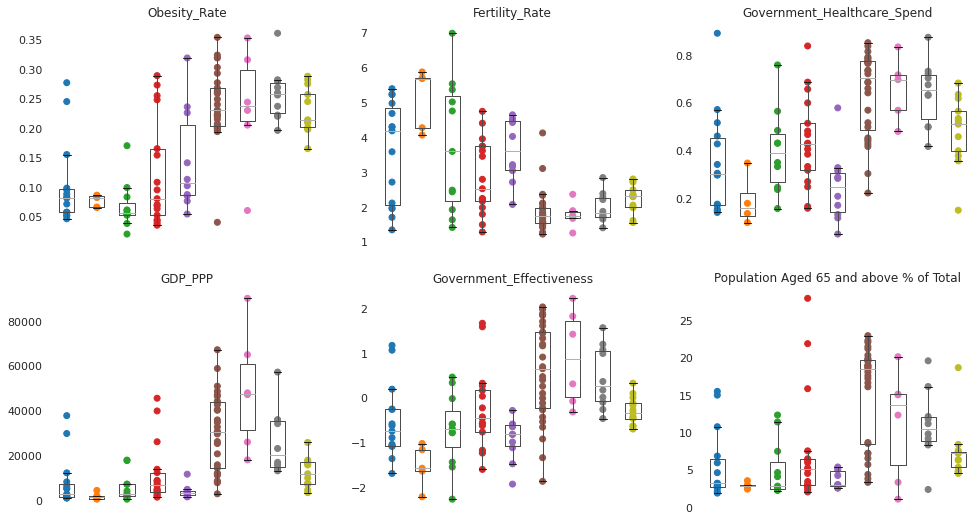

In [223]:
sns.set(style='white', rc={'figure.figsize':(16,9)})

columns=['Obesity_Rate','Fertility_Rate','Government_Healthcare_Spend','GDP_PPP','Government_Effectiveness','Population Aged 65 and above % of Total']
axes=[]
fig=plt.figure()

for i,column in enumerate(columns):
  axes.append(fig.add_subplot(2, int(.5+len(columns)/2), i+1))
  subplot_title=('\n'+column)
  axes[-1].set_title(subplot_title)  

  #plt.ylabel(column)
  plt.scatter(df_corr.labels+1,df_corr[column], c=cm.tab10(df_rol.labels))
  df_corr.boxplot(column,
               by=df_corr.labels, 
               ax=axes[-1],
               flierprops=dict(marker=None))

  plt.xlabel('')
  locs, _ = plt.xticks()
  #plt.xticks(locs,
  #         [df_14_day[df_14_day.labels==label].location.to_list()[0] for label in sorted(df_14_day.labels.unique())],
  #         fontsize=10)
  plt.xticks(locs,'')

  axes[-1].yaxis.grid(False)
  axes[-1].xaxis.grid(False)
  plt.gcf().suptitle(None)
  plt.box(False)
  plt.savefig('group_corr.png', dpi=300);